In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from numpy import set_printoptions
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [3]:
ames_data = pd.read_csv("AmesHousing.csv")
is_na_mask = ames_data.isna().sum()
missing_columns = is_na_mask[is_na_mask > 1000].index #these are the columns with over 1000 missing values, I want them gone
ames_data.drop(columns = missing_columns, inplace = True)
ames_data.dropna(inplace=True)

We will now separate the data into numerical data, categorical data, and a combination of the two.

In [4]:
#the numerical data
numerical_columns = ames_data.describe().columns
numerical_ames_data = ames_data[numerical_columns]
numerical_ames_data = numerical_ames_data.dropna()

In [5]:
#the categorical and combined data
#learned how to encode categorical columns from: https://medium.com/byteridge/encoding-categorical-values-in-python-scikit-learn-51b04b4bb5fa
categorical_columns = set(ames_data.columns).difference(set(numerical_columns))
categorical_df = ames_data[categorical_columns]
le = LabelEncoder()
encoded_categorical_df = categorical_df.astype(str).apply(le.fit_transform) #essentially this is transforming the categorical data into numerical 
combined_df = pd.concat([numerical_ames_data, encoded_categorical_df], axis=1, join_axes=[encoded_categorical_df.index]) #the encoded categorical data + the numerical data
encoded_categorical_df["SalePrice"] = ames_data["SalePrice"]

In [6]:
class Best_Features:
    '''Extracts the most important features in predicting house sale price using random forest and univariate selection techniques'''
    def __init__(self, k, input_df):
        '''K is the number of features you want displayed, input_df is the particular dataframe you're using'''
        self.k = k
        self.input_df = input_df
    
    def features_and_labels_generator(self):
        '''Splits the input dataframe into feature and label vectors'''
        feature_columns = set(self.input_df.columns).difference(set(["SalePrice"]))
        feature_vectors = np.array(self.input_df[feature_columns])
        class_labels = np.array(self.input_df["SalePrice"])
        return (feature_vectors, class_labels)
        
    def univariate_feature_selector(self):
        '''returns k best features for dataset based on univariate selection'''
        x,y = self.features_and_labels_generator()
        fs = SelectKBest(score_func=f_regression, k=self.k)
        # apply feature selection
        fit = fs.fit_transform(x, y)
        univariate_feature_columns = self.input_df.columns[fs.get_support(indices=True)]
        return univariate_feature_columns
    
    def random_forest_feature_selector(self):
        '''returns k best features for dataset based on random forest model'''
        x,y = self.features_and_labels_generator()
        total_x_train, total_x_test, total_y_train, total_y_test = train_test_split(x, y, test_size=0.25)
        feat_select_clf = RandomForestRegressor(n_estimators = 100, random_state=0)
        feat_select_clf.fit(total_x_train, total_y_train)
        important_features = list(zip(self.input_df.columns,feat_select_clf.feature_importances_))
        important_features.sort(key = lambda pair: pair[1], reverse = True)
        random_f_best_features = [pair[0] for pair in important_features[0:self.k]]
        return random_f_best_features
    
    def total_best_features(self):
        '''returns dataframe of intersection of univariate and random_forest features'''
        univariate_best_features = self.univariate_feature_selector()
        random_f_best_features = self.random_forest_feature_selector()
        total_best_features = list(set(univariate_best_features) & set(random_f_best_features))
        best_features_df = self.input_df[total_best_features]
        return best_features_df
        

In [7]:
numerical_features_obj = Best_Features(k=25,input_df=numerical_ames_data)
best_numerical_features = numerical_features_obj.total_best_features()

In [8]:
categorical_features_obj = Best_Features(k=25,input_df=encoded_categorical_df)
best_categorical_features = categorical_features_obj.total_best_features()

In [9]:
combined_features_obj = Best_Features(k=25, input_df=combined_df)
combined_features_obj.univariate_feature_selector()
best_combined_features = combined_features_obj.total_best_features()

C:\Users\Alex\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Alex\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Alex\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://

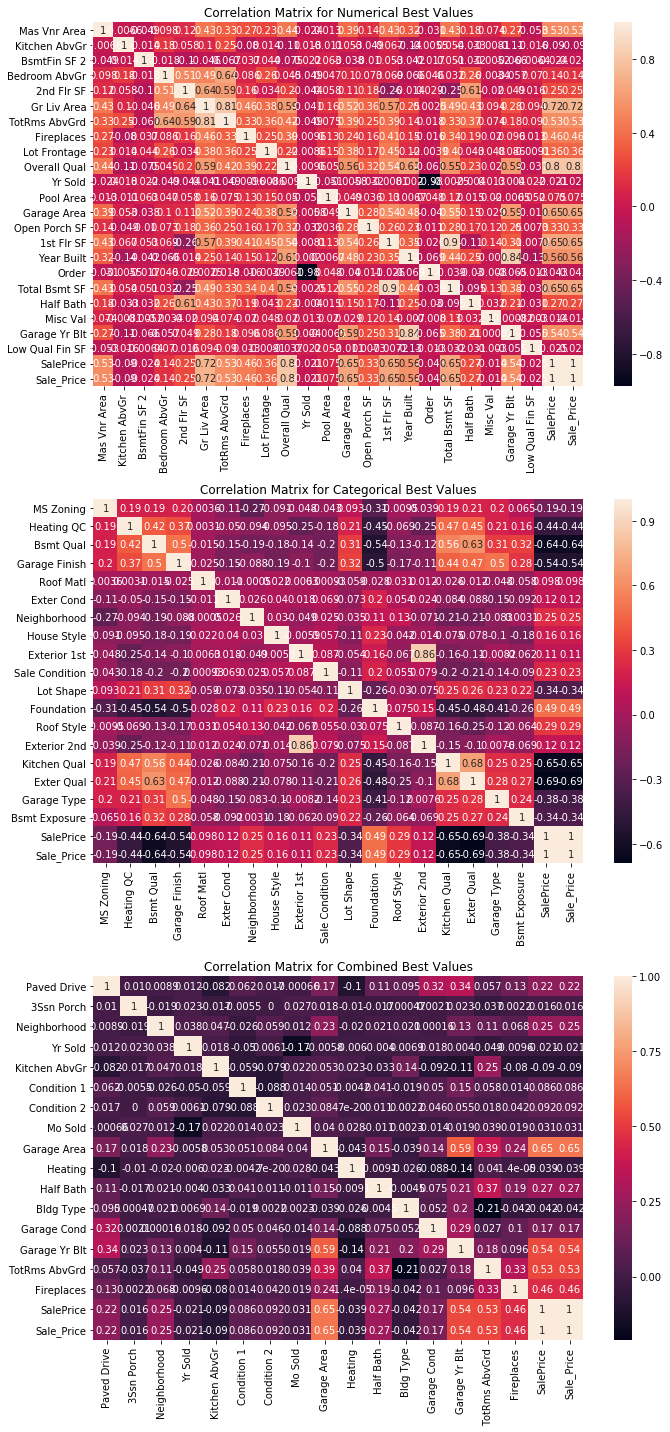

In [53]:
#correation matrix 



corr_data_num = best_numerical_features
corr_data_num['Sale_Price'] = ames_data['SalePrice']
corr_data_num_matrix = corr_data_num.corr()

corr_data_categorical = best_categorical_features
corr_data_categorical['Sale_Price'] =  ames_data['SalePrice']
corr_data_categorical_matrix = corr_data_categorical.corr()

corr_data_combined = best_combined_features
corr_data_combined['Sale_Price'] =  ames_data['SalePrice']
corr_data_combined_matrix = corr_data_combined.corr()



plt.figure(figsize=(10,20))


plt.subplot(3,1,1)
sn.heatmap(corr_data_num_matrix, annot=True)
plt.title("Correlation Matrix for Numerical Best Values")


plt.subplot(3,1,2)
sn.heatmap(corr_data_categorical_matrix, annot=True)
plt.title("Correlation Matrix for Categorical Best Values")
plt.tight_layout()

plt.subplot(3,1,3)
sn.heatmap(corr_data_combined_matrix, annot=True)
plt.title("Correlation Matrix for Combined Best Values")
plt.tight_layout()




In [11]:
def random_forest_predictor(input_features, input_labels = ames_data["SalePrice"]):
    '''function that takes in the best features for a given dataframe and returns the r squared value 
    as well as the root mean squared error using Random Forest Regression'''
    X_train, X_test, y_train, y_test = train_test_split(input_features, input_labels, test_size=0.25)
    regr = RandomForestRegressor(n_estimators=100, random_state=0)
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    root_mean_squared_error = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    r_squared_value = metrics.r2_score(y_test, y_pred)
    return (root_mean_squared_error, r_squared_value)

In [12]:
r2_list = []
error_list = []
feature_list = [best_categorical_features, best_numerical_features, best_combined_features]
label_list = ["Categorical Only", "Numerical Only", "Both"]
i = 0
for feature_df in feature_list:
    error, r2 = random_forest_predictor(input_features=feature_df)
    r2_list.append(r2)
    error_list.append(error)

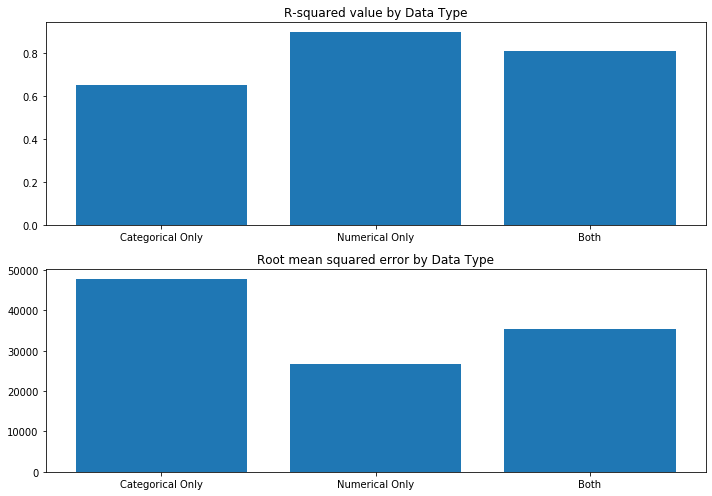

In [13]:
plt.figure(figsize=(10,7))


plt.subplot(2,1,1)
plt.bar(label_list, r2_list)
plt.title("R-squared value by Data Type")


plt.subplot(2,1,2)
plt.bar(label_list, error_list)
plt.title("Root mean squared error by Data Type")
plt.tight_layout()


So for the features for your chosen model, you can use either the best_numerical_features, best_categorical_features, or best_combined_features variables. The labels will be ames_data["SalePrice"].

In [19]:
best_numerical_features.head()

,Lot Area,Fireplaces,Bsmt Unf SF,PID,Open Porch SF,Year Built,Mo Sold,Garage Yr Blt,MS SubClass,Full Bath,...,3Ssn Porch,Low Qual Fin SF,Lot Frontage,Misc Val,Overall Qual,Yr Sold,Year Remod/Add,Bsmt Full Bath,Mas Vnr Area,Gr Liv Area
0,31770,2,441.0,526301100,62,1960,5,1960.0,20,1,...,0,0,141.0,0,6,2010,1960,1.0,112.0,1656
1,11622,0,270.0,526350040,0,1961,6,1961.0,20,1,...,0,0,80.0,0,5,2010,1961,0.0,0.0,896
2,14267,0,406.0,526351010,36,1958,6,1958.0,20,1,...,0,0,81.0,12500,6,2010,1958,0.0,108.0,1329
3,11160,2,1045.0,526353030,0,1968,4,1968.0,20,2,...,0,0,93.0,0,7,2010,1968,1.0,0.0,2110
4,13830,1,137.0,527105010,34,1997,3,1997.0,60,2,...,0,0,74.0,0,5,2010,1998,0.0,0.0,1629


In [56]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

def Linear_Regression(input_features, input_labels = ames_data['SalePrice']):
    #X is the chosen catergories that are going to be used for prediction
    X = input_features
    #y is the sales price
    y = input_labels

    #Splitting the data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    #Using linear regression model to fit the data
    reg = linear_model.LinearRegression()
    reg.fit(X_train, y_train)
    
    y_pred = reg.predict(X_test)
    root_mean_squared_error = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    
    #returns the R^2 of the predicted based on X_test and the actual y_test
    return root_mean_squared_error, reg.score(X_test, y_test)

In [57]:
r2_linear = []
error_linear = []
feature_list = [best_categorical_features, best_numerical_features, best_combined_features]
label_list = ["Categorical Only", "Numerical Only", "Both"]

for feature_df in feature_list:
    error, r2 = Linear_Regression(input_features=feature_df)
    r2_linear.append(r2)
    error_linear.append(error)

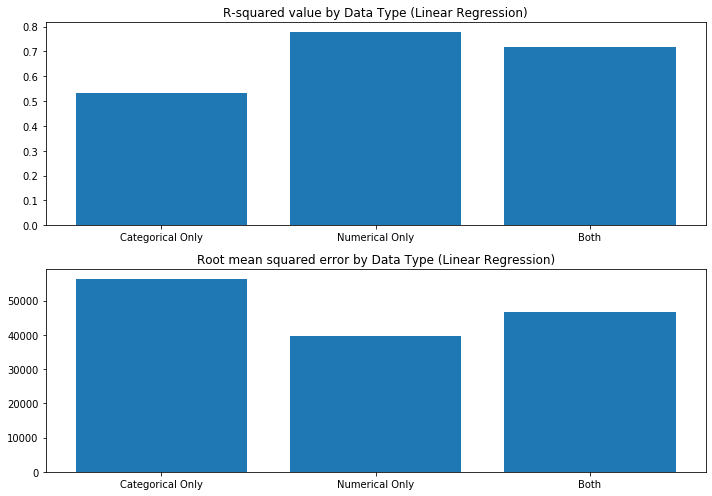

In [58]:
plt.figure(figsize=(10,7))


plt.subplot(2,1,1)
plt.bar(label_list, r2_linear)
plt.title("R-squared value by Data Type (Linear Regression)")


plt.subplot(2,1,2)
plt.bar(label_list, error_linear)
plt.title("Root mean squared error by Data Type (Linear Regression)")
plt.tight_layout()
